# COS80028 Data Science Capstone Project
## Assessing IT CourseAgainst Core Body of Knowledge -project7
#### Sai Harsha Vardhani Perla, 102869931
***

## Table Content
- [Data preparation](#a)
- [Creating Bigram and Trigram Models](#a2)
- [Remove Stopwords, Make Bigrams and Lemmatize ](#a3)
- [ Create the Dictionary and Corpus needed for Topic Modeling](#4)
- [ Building the Topic Model](#5)
- [View the topics in LDA model](#6)
- [ Compute Model Perplexity and Coherence Score ](#7)
- [Visualization ](#8)
- [finding the optimal number of topics for LDA ](#9)
- [Cbok Data set ](#10)
- [Data Preparation](#11)
- [ULO Data Set](#12)
- [Mapping with the Cbok ](#13)

## Requried Packages

In [1]:


#packges
import pandas as pd
import numpy as np
import re
import string

#spacy for lemmatization
import spacy


#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser


# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
nltk.download('stopwords')


#Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\HARSHA VARDHANI\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\HARSHA VARDHANI\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  meth

### Prepare stop words

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Importing Data set

In [3]:
ds = pd.read_csv('ds.csv') #ds(dataset of unitout lines )
ds.head() #decribe the dataset clearly

,Unit code,unit name,ULO no,Describption
0,COS60004,creating web applications,1,Describe the role of networking in the context...
1,COS60004,creating web applications,2,Demonstrate the use of mark up and presentatio...
2,COS60004,creating web applications,3,Demonstrate the use of server scripting and da...
3,COS60004,creating web applications,4,Describe the interaction between components of...
4,COS60004,creating web applications,5,Conduct a comparative analysis of contemporary...


## Data preparation <a name="a"></a>

#### Removing white spaces, newlines.

In [4]:
# Convert to list
data = ds.Describption.values.tolist()


data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

['Describe the role of networking in the context of web including tools to configure web clients and servers']


#### Tokinze words and clean up text 

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['describe', 'the', 'role', 'of', 'networking', 'in', 'the', 'context', 'of', 'web', 'including', 'tools', 'to', 'configure', 'web', 'clients', 'and', 'servers']]


### Creating Bigram and Trigram Models <a name="a2"></a>

##### Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.  
##### Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. 

In [6]:
#creating bigrams and trigrams 
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['describe', 'the', 'role', 'of', 'networking', 'in', 'the', 'context', 'of', 'web', 'including', 'tools', 'to', 'configure', 'web', 'clients', 'and', 'servers']


### Remove Stopwords, Make Bigrams and Lemmatize  <a name="a3"></a>

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#####  calling the functions in order.

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en
nlp = spacy.load("en_core_web_sm")

#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['describe', 'role', 'networking', 'context', 'web', 'include', 'tool', 'configure', 'web', 'client', 'server']]


### Create the Dictionary and Corpus needed for Topic Modeling <a name="a4"></a>

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2)]]


In [10]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]] #Human readable format of corpus (term-frequency)

[[('client', 1),
  ('configure', 1),
  ('context', 1),
  ('describe', 1),
  ('include', 1),
  ('networking', 1),
  ('role', 1),
  ('server', 1),
  ('tool', 1),
  ('web', 2)]]

##### For topic modeling, we have chossed 

### Building the Topic Model <a name="a5"></a>

In [11]:
#model creation with LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True) #chunksize is the number of documents to be used in each training chunk.update_every determines how often the model parameters should be updated andpasses is the total number of training passes.

### View the topics in LDA model <a name="a6"></a>

In [12]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.089*"visualisation" + 0.051*"strategy" + 0.050*"professional" + 0.043*"computer" + 0.043*"group" + 0.043*"machine" + 0.030*"awareness" + 0.023*"work" + 0.020*"reflect" + 0.020*"result"'), (1, '0.100*"concept" + 0.092*"structure" + 0.084*"model" + 0.078*"analysis" + 0.068*"principle" + 0.056*"system" + 0.053*"management" + 0.051*"environment" + 0.025*"organisational" + 0.024*"critically"'), (2, '0.102*"develop" + 0.080*"solution" + 0.078*"conduct" + 0.049*"design" + 0.035*"present" + 0.031*"generate" + 0.026*"work" + 0.020*"assignment" + 0.020*"documentation" + 0.020*"laboratory"'), (3, '0.137*"network" + 0.071*"modern" + 0.071*"architecture" + 0.067*"infrastructure" + 0.063*"design" + 0.058*"performance" + 0.027*"improve" + 0.017*"discuss" + 0.017*"osi" + 0.017*"model"'), (4, '0.074*"design" + 0.066*"text" + 0.045*"industry" + 0.036*"evaluate" + 0.030*"information" + 0.026*"modelling" + 0.024*"manipulate" + 0.024*"range" + 0.022*"code" + 0.021*"role"'), (5, '0.125*"small" + 0.0

### Compute Model Perplexity and Coherence Score <a name="a7"></a>

In [13]:
#computing the pperplexity conhenrence

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.057259336701945

Coherence Score:  0.38297249453993565


## Visualization  <a name="a8"></a>

### Visualize the topics-keywords

In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\HARSHA VARDHANI\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.290832 -0.078994       1        1  12.613881
8      0.115680 -0.242673       2        1   8.217069
11    -0.012908 -0.030202       3        1   6.865457
15     0.044221  0.123045       4        1   6.446216
16     0.091267 -0.167195       5        1   5.936956
17     0.078016  0.055105       6        1   5.815623
6     -0.172474 -0.017482       7        1   5.769856
1      0.117945 -0.030682       8        1   5.690029
5     -0.074508 -0.038331       9        1   5.276745
7     -0.020408  0.038418      10        1   5.193593
14     0.019032 -0.025475      11        1   5.076714
18     0.072169 -0.022403      12        1   4.353368
4     -0.000216  0.010648      13        1   3.687897
0      0.054411  0.076901      14        1   3.422866
2     -0.047426  0.049996      15        1   3.294496
12     0.076122  0.111822      16        1   3.126322
9     -0.041429  0.044033      17        1   2.932545
3     -0.118390  0.034534      18        1   2.366191
19     0.064915  0.078043      19        1   1.968095
10     0.044814  0.030893      20        1   1.946080, topic_info=               Term       Freq      Total Category  logprob  loglift
81          network  59.000000  59.000000  Default  30.0000  30.0000
53       technology  22.000000  22.000000  Default  29.0000  29.0000
179         program  27.000000  27.000000  Default  28.0000  28.0000
49            apply  33.000000  33.000000  Default  27.0000  27.0000
102         analyse  24.000000  24.000000  Default  26.0000  26.0000
..              ...        ...        ...      ...      ...      ...
49            apply   0.597239  33.732763  Topic20  -4.2152  -0.0946
494          emerge   0.039798   1.025258  Topic20  -6.9237   0.6905
401        business   0.039817   1.026601  Topic20  -6.9233   0.6896
365     communicate   0.039798   1.025466  Topic20  -6.9237   0.6903
372  object_oriente   0.039798   1.025516  Topic20  -6.9237   0.6902

[719 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
15        5  0.747490         access
15       11  0.106784         access
111       7  0.456290  accessibility
337       3  0.584204         accord
136      17  0.444595    acquisition
...     ...       ...            ...
135      10  0.345284           work
135      14  0.345284           work
135      15  0.345284           work
68        4  0.740633        working
202       6  0.939886          write

[512 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 9, 12, 16, 17, 18, 7, 2, 6, 8, 15, 19, 5, 1, 3, 13, 10, 4, 20, 11])

####  finding the optimal number of topics for LDA

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


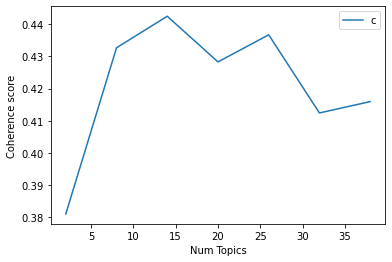

In [17]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3811
Num Topics = 8  has Coherence Value of 0.4327
Num Topics = 14  has Coherence Value of 0.4425
Num Topics = 20  has Coherence Value of 0.4283
Num Topics = 26  has Coherence Value of 0.4367
Num Topics = 32  has Coherence Value of 0.4124
Num Topics = 38  has Coherence Value of 0.416


In [19]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(16,
  '0.043*"program" + 0.032*"scripting" + 0.032*"language" + 0.022*"problem" + 0.022*"application" + 0.022*"create" + 0.022*"side" + 0.022*"use" + 0.022*"datum" + 0.022*"access"'),
 (10,
  '0.031*"system" + 0.031*"datum" + 0.031*"command" + 0.031*"design" + 0.031*"operating" + 0.031*"interface" + 0.016*"variety" + 0.016*"line" + 0.016*"technique" + 0.016*"semi"'),
 (9,
  '0.034*"use" + 0.034*"technical" + 0.017*"detect" + 0.017*"operate" + 0.017*"understand" + 0.017*"flaw" + 0.017*"corporate" + 0.017*"non" + 0.017*"analyse" + 0.017*"audience"'),
 (21,
  '0.038*"network" + 0.019*"future" + 0.019*"organisational" + 0.019*"ethic" + 0.019*"team" + 0.019*"interpret" + 0.019*"requirement" + 0.019*"router" + 0.019*"work" + 0.019*"prescriptive"'),
 (22,
  '0.028*"analyse" + 0.021*"term" + 0.021*"system" + 0.021*"management" + 0.021*"understand" + 0.021*"demonstrate" + 0.021*"business" + 0.021*"software" + 0.021*"quality" + 0.018*"code"'),
 (0,
  '0.039*"problem" + 0.039*"management" + 0.0

###### Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

C:\Users\HARSHA VARDHANI\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.142941 -0.020577       1        1  6.968226
16    -0.052408 -0.154512       2        1  4.382825
29    -0.070217 -0.045714       3        1  4.359551
2     -0.051304  0.039797       4        1  4.330817
28    -0.097447  0.149214       5        1  4.318768
27    -0.109227 -0.072835       6        1  4.235831
25    -0.048081  0.037012       7        1  4.231372
22    -0.037315  0.111741       8        1  3.960785
7     -0.075054  0.075821       9        1  3.826337
24    -0.107785  0.133833      10        1  3.700758
4     -0.018520  0.033442      11        1  3.528513
14    -0.043292 -0.126829      12        1  3.512532
19     0.203642  0.042437      13        1  3.462883
3      0.023360 -0.030349      14        1  3.387326
8      0.023822 -0.025330      15        1  3.287583
6      0.116444 -0.084050      16        1  3.273388
11    -0.006458 -0.005957      17        1  2.885745
1      0.006787 -0.072088      18        1  2.729164
30    -0.051190  0.002374      19        1  2.691432
20     0.146872  0.066575      20        1  2.681626
26    -0.087874 -0.047687      21        1  2.643072
10     0.022939 -0.058783      22        1  2.439937
9      0.028256  0.094589      23        1  2.274298
17     0.045975  0.097350      24        1  2.245197
13     0.063990 -0.171945      25        1  2.199946
23     0.078664 -0.022478      26        1  2.123379
31    -0.036944 -0.035988      27        1  1.874376
12    -0.010080 -0.048700      28        1  1.854727
0      0.030556 -0.000859      29        1  1.772207
21     0.149047  0.029387      30        1  1.720214
15     0.086607  0.048926      31        1  1.615985
18     0.019176  0.062183      32        1  1.481200, topic_info=            Term       Freq      Total Category  logprob  loglift
81       network  26.000000  26.000000  Default   30.000  30.0000
17         datum  20.000000  20.000000  Default   29.000  29.0000
69        design  36.000000  36.000000  Default   28.000  28.0000
83    management  12.000000  12.000000  Default   27.000  27.0000
257      problem  15.000000  15.000000  Default   26.000  26.0000
..           ...        ...        ...      ...      ...      ...
184       medium   0.021361   1.199044  Topic32   -7.273   0.1846
383       object   0.021361   1.794816  Topic32   -7.273  -0.2188
397    associate   0.021361   2.831115  Topic32   -7.273  -0.6745
371  inheritance   0.021361   1.287669  Topic32   -7.273   0.1133
373     paradigm   0.021361   1.287668  Topic32   -7.273   0.1133

[1381 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
412       1  0.599500      ability
369      25  0.776604  abstraction
389      27  0.726187       accept
15        1  0.152332       access
15        2  0.304663       access
...     ...       ...          ...
202       2  0.313873        write
202       3  0.156936        write
202      19  0.156936        write
202      22  0.156936        write
202      24  0.156936        write

[1654 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 17, 30, 3, 29, 28, 26, 23, 8, 25, 5, 15, 20, 4, 9, 7, 12, 2, 31, 21, 27, 11, 10, 18, 14, 24, 32, 13, 1, 22, 16, 19])

###  finding the optimal number of topics for LDA <a name="a9"></a>

In [21]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9193,"web, describe, tool, critically, evaluate, ana...",Describe the role of networking in the context...
1,1,16.0,0.8616,"program, scripting, language, problem, applica...",Demonstrate the use of mark up and presentatio...
2,2,16.0,0.8789,"program, scripting, language, problem, applica...",Demonstrate the use of server scripting and da...
3,3,6.0,0.9308,"issue, language, programming, demonstrate, dat...",Describe the interaction between components of...
4,4,14.0,0.9308,"structure, develop, describe, result, technolo...",Conduct a comparative analysis of contemporary...
5,5,18.0,0.6771,"appropriate, textual, static, behaviour, criti...",Have an understanding of programming
6,6,8.0,0.8616,"technology, class, control, collection, inform...","Demonstrate reflective practice, and use self ..."
7,7,14.0,0.5556,"structure, develop, describe, result, technolo...",Apply knowledge of programming fundamentals to...
8,8,28.0,0.8062,"team, variety, development, multi, loop, profe...",Learn collaboratively in a team environment
9,9,8.0,0.9031,"technology, class, control, collection, inform...","Find, organise, and evaluate information on a ..."


### Finding the most representative document for each topic

In [22]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mlda = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mlda = pd.concat([sent_topics_sorteddf_mlda, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mlda.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mlda.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mlda.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9490,"problem, management, process, compete, static,...","Apply problem solving, design and decision mak..."
1,1.0,0.9193,"technology, network, design, report, explain, ...",Select technologies for data storage and physi...
2,2.0,0.9462,"web, describe, tool, critically, evaluate, ana...",Critically evaluate the concepts of descriptiv...
3,3.0,0.9395,"network, practical, issue, design, datum, scie...",Demonstrate understanding of the lifecycle of ...
4,4.0,0.9308,"system, model, use, design, operating, context...","Analyse software context of use (i.e., users, ..."


#### Topic distribution across documents

In [23]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"web, describe, tool, critically, evaluate, ana...",4.0,0.0176
1.0,16.0,"program, scripting, language, problem, applica...",9.0,0.0396
2.0,16.0,"program, scripting, language, problem, applica...",9.0,0.0396
3.0,6.0,"issue, language, programming, demonstrate, dat...",9.0,0.0396
4.0,14.0,"structure, develop, describe, result, technolo...",9.0,0.0396
...,...,...,...,...
222.0,1.0,"technology, network, design, report, explain, ...",NaN,NaN
223.0,1.0,"technology, network, design, report, explain, ...",NaN,NaN
224.0,10.0,"system, datum, command, design, operating, int...",NaN,NaN
225.0,16.0,"program, scripting, language, problem, applica...",NaN,NaN


In [24]:
df_dominant_topics.to_csv('keyword.csv') #convertingand saving the the data frame into csvfile

## Cbok Data set <a name="a10"></a>

#### loading the data set

In [25]:
ulo = pd.read_csv('ULODS.csv')#it
cbds = pd.read_csv('cbook.csv')
#cbds.head() #decribe the dataset clearly
#ulo.head()
display( ulo.head() )
display( cbds.head() )

,Unitcode,unitname,ULOno,Describption,Unnamed: 4,Topic_Keywords
0,COS60004,creating web applications,1,Describe the role of networking in the context...,NaN,"business, tool, network, role, small, term, st..."
1,COS60004,creating web applications,2,Demonstrate the use of mark up and presentatio...,NaN,"design, wide, internet, web, network, security..."
2,COS60004,creating web applications,3,Demonstrate the use of server scripting and da...,NaN,"scripting, side, attack, language, access, dat..."
3,COS60004,creating web applications,4,Describe the interaction between components of...,NaN,"web, issue, business, development, describe, a..."
4,COS60004,creating web applications,5,Conduct a comparative analysis of contemporary...,NaN,"technology, design, service, develop, apply, u..."


,knowledge number,knowledge,Descrbipition,Unnamed: 3
0,1.1,Ethics,"• Fundamental ethical notions (virtues, duty, ...",NaN
1,1.2,Professional expectations,"Topics covered should include: expertise, cert...",NaN
2,1.3,Teamwork concepts and issues,"Topics covered should include: collaboration, ...",NaN
3,1.4,Interpersonal communication,Topics covered should include: oral and writte...,NaN
4,1.5,Societal issues/legal issues/privacy,Topics covered should include: history of comp...,NaN


### Data Preparation<a name="a11"></a>

In [26]:
def text_preprocess(series, stemmer, stopwords):
    ds = series.str.replace("\n\t",  " ")
    ds = ds.str.replace(r"[^a-zA-Z ]+", "")
    ds = ds.str.lower()
    ds = ds.apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split() if item not in stopwords]))
    
    return ds

In [27]:
from nltk.stem import PorterStemmer

stopwords = nltk.corpus.stopwords.words('english')

stemmer = PorterStemmer() 

##### cleaning the Descrbipition column

In [28]:
cbds['cbok_clean_text'] = text_preprocess(cbds['Descrbipition'], stemmer, stopwords)
cbds.head()

<ipython-input-26-188f068688fb>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  ds = ds.str.replace(r"[^a-zA-Z ]+", "")


,knowledge number,knowledge,Descrbipition,Unnamed: 3,cbok_clean_text
0,1.1,Ethics,"• Fundamental ethical notions (virtues, duty, ...",NaN,fundament ethic notion virtu duti respons harm...
1,1.2,Professional expectations,"Topics covered should include: expertise, cert...",NaN,topic cover includ expertis certif compet auto...
2,1.3,Teamwork concepts and issues,"Topics covered should include: collaboration, ...",NaN,topic cover includ collabor group dynam leader...
3,1.4,Interpersonal communication,Topics covered should include: oral and writte...,NaN,topic cover includ oral written present techni...
4,1.5,Societal issues/legal issues/privacy,Topics covered should include: history of comp...,NaN,topic cover includ histori comput ict discipli...


In [29]:
cbds = cbds.drop('Unnamed: 3', 1)

<ipython-input-29-7d7094642baa>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  cbds = cbds.drop('Unnamed: 3', 1)


In [30]:
cbds.head()

,knowledge number,knowledge,Descrbipition,cbok_clean_text
0,1.1,Ethics,"• Fundamental ethical notions (virtues, duty, ...",fundament ethic notion virtu duti respons harm...
1,1.2,Professional expectations,"Topics covered should include: expertise, cert...",topic cover includ expertis certif compet auto...
2,1.3,Teamwork concepts and issues,"Topics covered should include: collaboration, ...",topic cover includ collabor group dynam leader...
3,1.4,Interpersonal communication,Topics covered should include: oral and writte...,topic cover includ oral written present techni...
4,1.5,Societal issues/legal issues/privacy,Topics covered should include: history of comp...,topic cover includ histori comput ict discipli...


#### ULO Data Set <a name="a12"></a>

In [31]:
ulo = pd.read_csv('ULODS.csv')
display( ulo.head() ) 


,Unitcode,unitname,ULOno,Describption,Unnamed: 4,Topic_Keywords
0,COS60004,creating web applications,1,Describe the role of networking in the context...,NaN,"business, tool, network, role, small, term, st..."
1,COS60004,creating web applications,2,Demonstrate the use of mark up and presentatio...,NaN,"design, wide, internet, web, network, security..."
2,COS60004,creating web applications,3,Demonstrate the use of server scripting and da...,NaN,"scripting, side, attack, language, access, dat..."
3,COS60004,creating web applications,4,Describe the interaction between components of...,NaN,"web, issue, business, development, describe, a..."
4,COS60004,creating web applications,5,Conduct a comparative analysis of contemporary...,NaN,"technology, design, service, develop, apply, u..."


###### topic_keywords is the tokens from the describption of the units

In [32]:
ulo = ulo.drop('Unnamed: 4', 1)

<ipython-input-32-56d9ae7e96d1>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ulo = ulo.drop('Unnamed: 4', 1)


### Mapping with the Cbok <a name="a13"></a>

##### As, we need to map the text here we are using the Fussywuzzy. Fuzzywuzzy is used for matching the cloumns in the data frame basing on the string similarity.  As, it is text mapping we are using the string mapping  to match between the columns.

In [33]:
from fuzzywuzzy import process, fuzz
knowledge = []
similarity_TK = [] #similarity of Topic_keywords and knowlegde of cbok(which are networking,cyber security like that catgory)
for i in  ulo.Topic_Keywords:
        ratio = process.extract( i, cbds.knowledge, limit=1)
        knowledge.append(ratio[0][0])
        #unitname.append(ratio[0][0])
        #Unitcode.append(ratio[0][0])	
        similarity_TK.append(ratio[0][1])

ulo['topic_key_knowledge'] = pd.Series(knowledge)
ulo['similarity_TK'] = pd.Series(similarity_TK)

ulo.head(15)

C:\Users\HARSHA VARDHANI\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


,Unitcode,unitname,ULOno,Describption,Topic_Keywords,topic_key_knowledge,similarity_TK
0,COS60004,creating web applications,1,Describe the role of networking in the context...,"business, tool, network, role, small, term, st...",Networking,63
1,COS60004,creating web applications,2,Demonstrate the use of mark up and presentatio...,"design, wide, internet, web, network, security...",Cyber security,86
2,COS60004,creating web applications,3,Demonstrate the use of server scripting and da...,"scripting, side, attack, language, access, dat...",Societal issues/legal issues/privacy,86
3,COS60004,creating web applications,4,Describe the interaction between components of...,"web, issue, business, development, describe, a...",Systems development and acquisition,86
4,COS60004,creating web applications,5,Conduct a comparative analysis of contemporary...,"technology, design, service, develop, apply, u...",Service management,86
5,COS60010,Technology Enquiry Project,1,Have an understanding of programming,"evaluate, datum, code, apply, interpret, visua...",Data and information management,86
6,COS60010,Technology Enquiry Project,2,"Demonstrate reflective practice, and use self ...","practice, evaluation, reflective, peer, self, ...",Hardware and software fundamentals,86
7,COS60010,Technology Enquiry Project,3,Apply knowledge of programming fundamentals to...,"design, database, technology, big, build, know...",Networking,48
8,COS60010,Technology Enquiry Project,4,Learn collaboratively in a team environment,"practice, evaluation, reflective, peer, self, ...",Hardware and software fundamentals,86
9,COS60010,Technology Enquiry Project,5,"Find, organise, and evaluate information on a ...","use, describe, relate, switch, security, issue...",Cyber security,86


In [34]:
cbok_clean_text= []
similarity_TD = [] #similarity of keywords and descrpition of cbok
for i in  ulo.Topic_Keywords:
        ratio = process.extract( i, cbds.cbok_clean_text, limit=1)
        cbok_clean_text.append(ratio[0][0])
        similarity_TD.append(ratio[0][1])

ulo['topic_key_Descrbipition'] = pd.Series(cbok_clean_text)
ulo['similarity_TD'] = pd.Series(similarity_TD)

ulo.head(10)

,Unitcode,unitname,ULOno,Describption,Topic_Keywords,topic_key_knowledge,similarity_TK,topic_key_Descrbipition,similarity_TD
0,COS60004,creating web applications,1,Describe the role of networking in the context...,"business, tool, network, role, small, term, st...",Networking,63,area requir understand data commun network fun...,86
1,COS60004,creating web applications,2,Demonstrate the use of mark up and presentatio...,"design, wide, internet, web, network, security...",Cyber security,86,area requir understand data commun network fun...,86
2,COS60004,creating web applications,3,Demonstrate the use of server scripting and da...,"scripting, side, attack, language, access, dat...",Societal issues/legal issues/privacy,86,area requir understand data commun network fun...,86
3,COS60004,creating web applications,4,Describe the interaction between components of...,"web, issue, business, development, describe, a...",Systems development and acquisition,86,understand requir data captur repres organis r...,86
4,COS60004,creating web applications,5,Conduct a comparative analysis of contemporary...,"technology, design, service, develop, apply, u...",Service management,86,understand requir data captur repres organis r...,86
5,COS60010,Technology Enquiry Project,1,Have an understanding of programming,"evaluate, datum, code, apply, interpret, visua...",Data and information management,86,fundament ethic notion virtu duti respons harm...,86
6,COS60010,Technology Enquiry Project,2,"Demonstrate reflective practice, and use self ...","practice, evaluation, reflective, peer, self, ...",Hardware and software fundamentals,86,involv understand fundament concept program la...,86
7,COS60010,Technology Enquiry Project,3,Apply knowledge of programming fundamentals to...,"design, database, technology, big, build, know...",Networking,48,understand requir develop acquir softwar infor...,86
8,COS60010,Technology Enquiry Project,4,Learn collaboratively in a team environment,"practice, evaluation, reflective, peer, self, ...",Hardware and software fundamentals,86,involv understand fundament concept program la...,86
9,COS60010,Technology Enquiry Project,5,"Find, organise, and evaluate information on a ...","use, describe, relate, switch, security, issue...",Cyber security,86,involv understand fundament concept program la...,86


##### from the above cell we can see that we have taken similarity with the topic key words of ulos and we have similarites.  Similarty_TK this represents the similarty of the string with topic keyowrds and cbok knowledge. Simlarity_TD this represents the similarites of  topic key words and knowldge decbrption cbok. As, a result this mapping correctly with topic_key words of ULO and also the knowldge and descrpition as well.

In [35]:
ulo.rename({'topic_key_knowledge': 'Cbok_category', 'topic_key_Descrbipition': 'Cbok_Category_dec','similarity_TD':'Similarity_Score'}, axis=1, inplace=True)
ulo.head()
#renaming the column names

,Unitcode,unitname,ULOno,Describption,Topic_Keywords,Cbok_category,similarity_TK,Cbok_Category_dec,Similarity_Score
0,COS60004,creating web applications,1,Describe the role of networking in the context...,"business, tool, network, role, small, term, st...",Networking,63,area requir understand data commun network fun...,86
1,COS60004,creating web applications,2,Demonstrate the use of mark up and presentatio...,"design, wide, internet, web, network, security...",Cyber security,86,area requir understand data commun network fun...,86
2,COS60004,creating web applications,3,Demonstrate the use of server scripting and da...,"scripting, side, attack, language, access, dat...",Societal issues/legal issues/privacy,86,area requir understand data commun network fun...,86
3,COS60004,creating web applications,4,Describe the interaction between components of...,"web, issue, business, development, describe, a...",Systems development and acquisition,86,understand requir data captur repres organis r...,86
4,COS60004,creating web applications,5,Conduct a comparative analysis of contemporary...,"technology, design, service, develop, apply, u...",Service management,86,understand requir data captur repres organis r...,86


#### creating the final data set Cbokmapping

In [36]:
Cbok_mapping = ulo[['ULOno','Cbok_category','Cbok_Category_dec','unitname','Topic_Keywords','Similarity_Score']]
Cbok_mapping.head(10)

,ULOno,Cbok_category,Cbok_Category_dec,unitname,Topic_Keywords,Similarity_Score
0,1,Networking,area requir understand data commun network fun...,creating web applications,"business, tool, network, role, small, term, st...",86
1,2,Cyber security,area requir understand data commun network fun...,creating web applications,"design, wide, internet, web, network, security...",86
2,3,Societal issues/legal issues/privacy,area requir understand data commun network fun...,creating web applications,"scripting, side, attack, language, access, dat...",86
3,4,Systems development and acquisition,understand requir data captur repres organis r...,creating web applications,"web, issue, business, development, describe, a...",86
4,5,Service management,understand requir data captur repres organis r...,creating web applications,"technology, design, service, develop, apply, u...",86
5,1,Data and information management,fundament ethic notion virtu duti respons harm...,Technology Enquiry Project,"evaluate, datum, code, apply, interpret, visua...",86
6,2,Hardware and software fundamentals,involv understand fundament concept program la...,Technology Enquiry Project,"practice, evaluation, reflective, peer, self, ...",86
7,3,Networking,understand requir develop acquir softwar infor...,Technology Enquiry Project,"design, database, technology, big, build, know...",86
8,4,Hardware and software fundamentals,involv understand fundament concept program la...,Technology Enquiry Project,"practice, evaluation, reflective, peer, self, ...",86
9,5,Cyber security,involv understand fundament concept program la...,Technology Enquiry Project,"use, describe, relate, switch, security, issue...",86


In [37]:
Cbok_mapping.to_csv('Cbok_mapping_outcomes.csv') #saving the Cbok_mapping dataset to csv file as Cbok_mapping_outcomes